In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report
import sklearn.metrics as metrics
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from scipy.stats import randint

train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

X = train.drop('label', axis=1).values
y = train['label'].values

# Reshape the data to fit the model (28x28 pixels, 1 channel)
if isinstance(test, pd.DataFrame):
    test = test.values

X = X.reshape(-1, 28, 28, 1)
# test = test.values.reshape(-1, 28, 28, 1)
test = test.reshape(-1, 28, 28, 1)

# Normalize the data
X = X / 255.0
test = test / 255.0

# Split data into training and validation sets
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=10)
y_val = to_categorical(y_val, num_classes=10)

X_train = train.iloc[:, 1:].values.reshape(-1, 28, 28, 1) / 255.0
y_train = train.iloc[:, 0].values
X_test = test.reshape(-1, 28, 28, 1) / 255.0


from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_val shape: {X_val.shape}")
print(f"y_val shape: {y_val.shape}")
print(f"X_test shape: {X_test.shape}")


X_train shape: (33600, 28, 28, 1)
y_train shape: (33600,)
X_val shape: (8400, 28, 28, 1)
y_val shape: (8400,)
X_test shape: (28000, 28, 28, 1)


In [10]:
import keras_tuner as kt
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential
import tensorflow as tf

# Define the model-building function
def build_model(hp):
    model = Sequential()
    model.add(Conv2D(filters=hp.Int('filters', min_value=32, max_value=128, step=32),
                     kernel_size=hp.Choice('kernel_size', values=[3, 5]),
                     activation='relu',
                     input_shape=(28, 28, 1)))
    model.add(MaxPooling2D(pool_size=2))
    
    if hp.Boolean('additional_conv_layer'):
        model.add(Conv2D(filters=hp.Int('filters2', min_value=32, max_value=128, step=32),
                         kernel_size=hp.Choice('kernel_size2', values=[3, 5]),
                         activation='relu'))
        model.add(MaxPooling2D(pool_size=2))
    
    model.add(Flatten())
    model.add(Dense(units=hp.Int('units', min_value=32, max_value=128, step=32), activation='relu'))
    model.add(Dropout(rate=hp.Float('dropout', min_value=0.0, max_value=0.5, step=0.1)))
    model.add(Dense(10, activation='softmax'))
    model.compile(optimizer=Adam(hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])),
                  loss='sparse_categorical_crossentropy',
                  metrics=['accuracy'])
    return model

# Set up Randomized Search
tuner = kt.RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=20,
    executions_per_trial=1,
    directory='my_dir',
    project_name='mnist_tuning'
)

# Perform the search
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3)
tuner.search(X_train, y_train, epochs=20, validation_split=0.2, callbacks=[early_stopping])

# Retrieve the best model
best_model = tuner.get_best_models(num_models=1)[0]
best_model.summary()

Trial 3 Complete [00h 02m 13s]
val_accuracy: 0.9770833253860474

Best val_accuracy So Far: 0.9860119223594666
Total elapsed time: 00h 05m 07s

Search: Running Trial #4

Value             |Best Value So Far |Hyperparameter
96                |64                |filters
5                 |5                 |kernel_size
False             |False             |additional_conv_layer
96                |64                |units
0.1               |0.3               |dropout
0.001             |0.001             |learning_rate
32                |None              |filters2
5                 |None              |kernel_size2

Epoch 1/20
  9/840 [..............................] - ETA: 24s - loss: 1.9055 - accuracy: 0.3576

KeyboardInterrupt: 

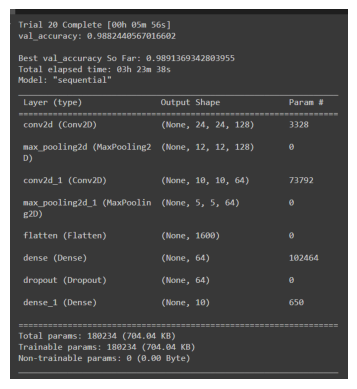

In [ ]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

img = mpimg.imread('hyperparameter results.PNG')
plt.imshow(img)
plt.axis('off')  
plt.show()

#image was retrieved from google collab

The hyperparameters include:

- Number of filters and kernel size for convolutional layers
- Whether to include an additional convolutional layer
- Number of units in the dense layer
- Dropout rate
- Learning rate

The RandomSearch tuner from Keras Tuner. 

It:
- Uses the build_model function to create models with different hyperparameters
- Limits the number of trials to 20